# Image processing

This notebook demonstrates some of the possibilities offered by `scikit-rt` for image cropping, resampling, translation, size matching, and intensity banding.  These operations can be useful as pre-processing for registration and segmentation, and for other analyses.

Documentation for `scikit-rt` is at:  
[https://scikit-rt.github.io/scikit-rt/](https://scikit-rt.github.io/scikit-rt/)


This notebook uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)  
https://doi.org/10.6084/m9.figshare.12579707.v1

**Note:** If not already present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` in the
first code cell below.  The download file has a size of 1.6 GB, so download may take a while.

## Module import and data download

The following imports modules needed in this notebook, defines the path to the data directory, downloads the example dataset if not already present, obtains the list of paths to patient folders, and sets some viewer options.

In [1]:
from pathlib import Path
from skrt import BetterViewer, Patient
from skrt.core import alphanumeric, compress_user, download, Defaults
from skrt.dose import sum_doses

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)
    
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
# Defaults().compress_user = True

## Sample data

The following defines some sample data.  The indices for the paths to patient folders can be changed, but the ROIs outlined, and their labels, may need to be adjusted.

In [2]:
# Map possible ROI labels (dictionary values)
# to standardised names (dictionary keys).
roi_names = {
    "heart": "heart",
    "lung_left": "lung_l*",
    "lung_right": "lung_r*",
    "spinal_cord": ["cord*", "spinal*cord"],
}

# Load data from selected paths.
indices = [10, 16]
patients = [Patient(paths[idx], unsorted_dicom=True) for idx in indices]

# Obtain references to filtered structure sets.
structure_sets = [p.get_structure_sets("ct")[0].filtered_copy(names=roi_names, keep_renamed_only=True)
                  for p in patients]

# Obtain references to ct images linked to structure sets.
images = [ss.get_image() for ss in structure_sets]

# Assign filtered structure sets to images.
# (Without this, a single image may be linked to multiple structure sets.)
[im.assign_structure_set(ss) for im, ss in zip(images, structure_sets)]

# Obtain references to summed doses.
doses = [sum_doses(im.get_doses()) for im in images]

## Image cropping

Cropping an image can be useful in removing data of limited value for solving a particular problem.  It can help focus an auto-segmentation algorithm on the region(s) that are most relevant, reduce memory requirements, and reduce computing times.

`Scikit-rt` offers a number of options for image cropping, as shown in the examples below.  In the examples, images are cloned before cropping, to avoid changing the originals.  Crop amounts are in millimetres.  Cropped images are displayed with (uncropped) structure sets superimposed.

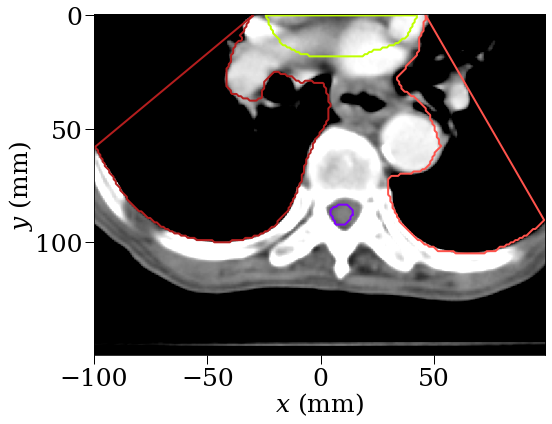

In [3]:
# Crop to a specified region.
im1 = images[0].clone(); im1.crop(xlim=(-100,100), ylim=(0, 150), zlim=None)
im1.view(rois=structure_sets[0]);

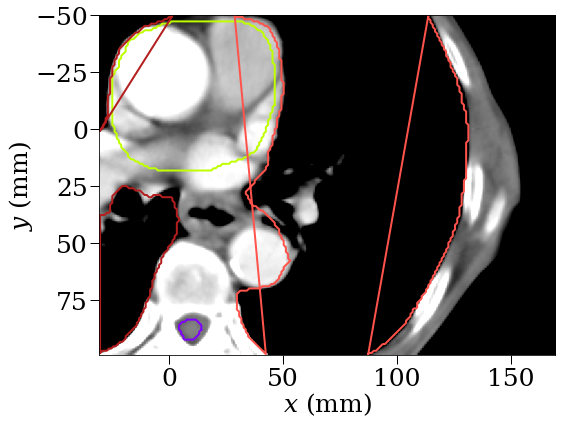

In [4]:
# Crop about a point.
im2 = images[0].clone(); im2.crop_about_point(point=(70, -50, 0), xlim=(-100,100), ylim=(0, 150), zlim=None)
im2.view(rois=structure_sets[0]);

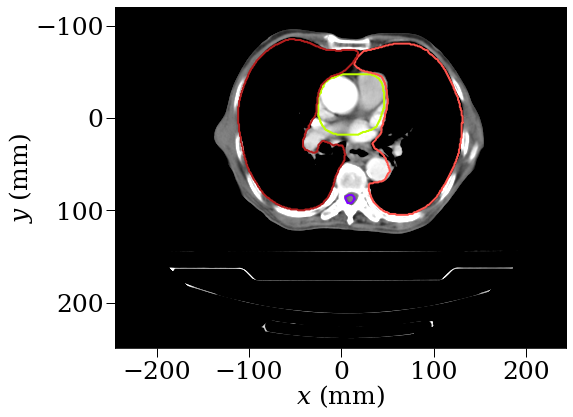

In [5]:
# Crop by specified amounts.
im3 = images[0].clone(); im3.crop_by_amounts(dx=5, dy=(130, 0), dz=None)
im3.view(rois=structure_sets[0]);

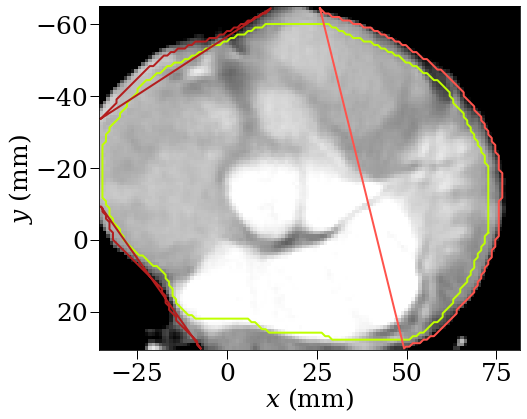

In [6]:
# Crop to an ROI.
im4 = images[0].clone(); im4.crop_to_roi(structure_sets[0]["heart"])
im4.view(rois=structure_sets[0]);

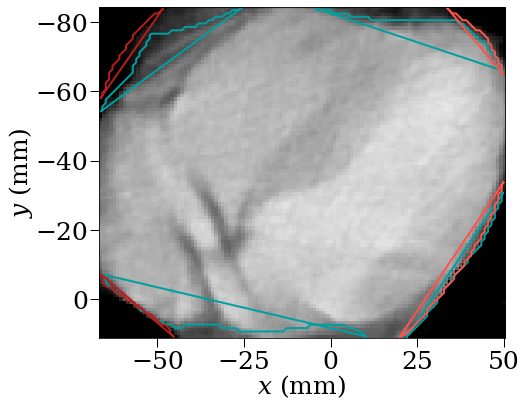

In [7]:
# Crop to another image, optionally aligning on an ROI before cropping.
im5 = images[1].clone(); im5.crop_to_image(im4, "heart")
im5.view(rois=structure_sets[1]);

## Image resampling

Matching of image voxel sizes can be achieved through resampling, as shown in the examples below.  In the examples, images are cloned before resampling, to avoid changing the originals.  Voxel sizes are in millimetres.

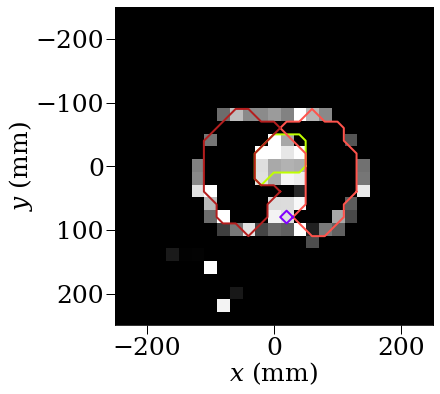

In [8]:
# Resample image to specified voxel size.
im6 = images[0].clone(); im6.resample(voxel_size=20)
im6.view(rois=structure_sets[0]);

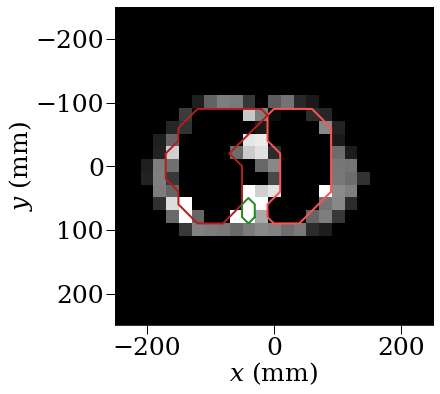

In [9]:
# Resample image to voxel size of another image
im7 = images[1].clone(); im7.resample(voxel_size=im6.get_voxel_size())
im7.view(rois=structure_sets[1]);

## Image translation

Translating an image can give a better starting position for image registration.  `Scikit-rt` can provide an estimate of the translation needed to align images on a relative location, or on an ROI.  Translation can be achieved through a similarity transform or by redefining origin coordinates.  When a similarity transform is applied, the coordinates of image slices are fixed, and imaged objects are moved relative to the slices.  When origin coordinates are redefined, the coordinates of image slices are changed, and imaged objects are fixed relative to the slices.

Structure sets can be translated in the same way as images.

Example translations are shown below.  In the examples, image and structure set are cloned before translating, to avoid changing the originals.  Translations are in millimeters.

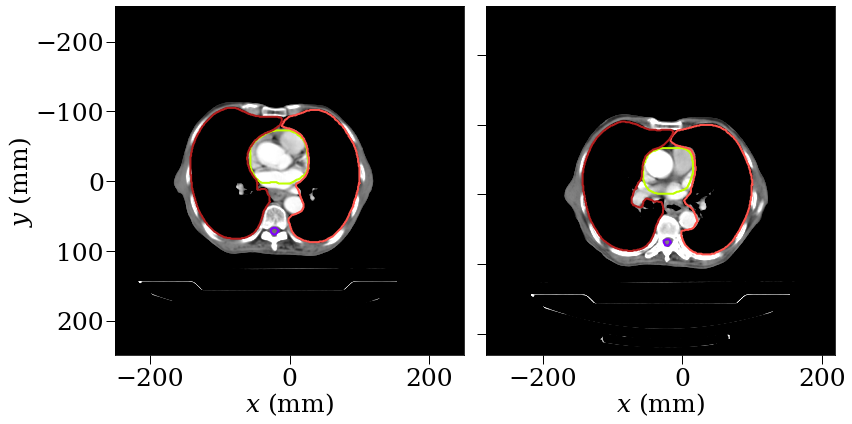

In [10]:
# Estimate translation to align images on heart centroids.
translation = images[0].get_alignment_translation(images[1], "heart")

# Translate image through similarity transform.
im8 = images[0].clone(); im8.transform(translation=translation)

# Translate image by redefining origin coordinates.
im9 = images[0].clone(); im9.translate_origin(translation=translation)

# Translate structure set.
ss8 = structure_sets[0].clone(); ss8.transform(translation=translation)

# View translated images, with translated structure sets superimposed.
im8.view(im9, rois=[ss8, ss8]);

## Image resizing

Images and dose fields can sometimes be in the same frame of reference but cover different regions.  This can be corrected in `scikit-rt` through size matching.  In the example below, the dose field is resized to match the image to which it relates.

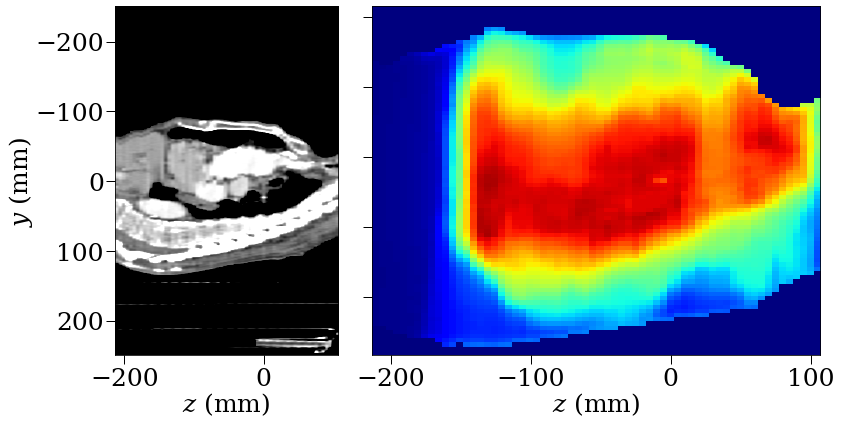

In [11]:
# View image and associated dose field side by side.
# (Trying to superimpose the dose field on an image of different size
# may give a result that looks reasonable, may display incorrectly,
# or may generate an error.)
images[0].view(images=doses[0], init_view="z-y");

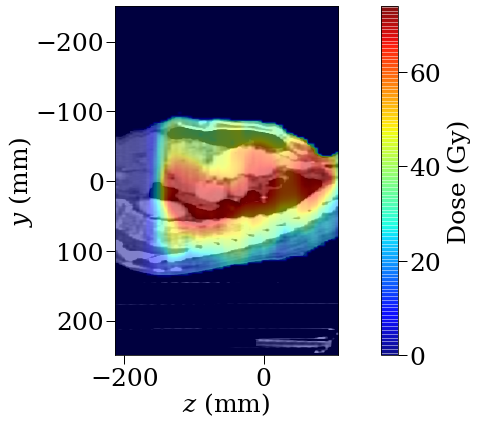

In [12]:
# Clone, then resize, dose field
dose = doses[0].clone(); dose.match_size(images[0])

# View image with resized dose field superimposed.
images[0].view(dose=dose, colorbar=-1, init_view="z-y");

## Intensity banding

As a first stage in auto-segmentation, it can be useful to reduce intensity fluctuations, and instead represent bands of intensity values by a single value.  An example of this is shown below, where intensities of -100 HU and lower have been set to -1024 HU, intensities greater than -100 HU and up to 100 HU have been set to 0, and intensities above 100 HU have been set to 1024 HU.

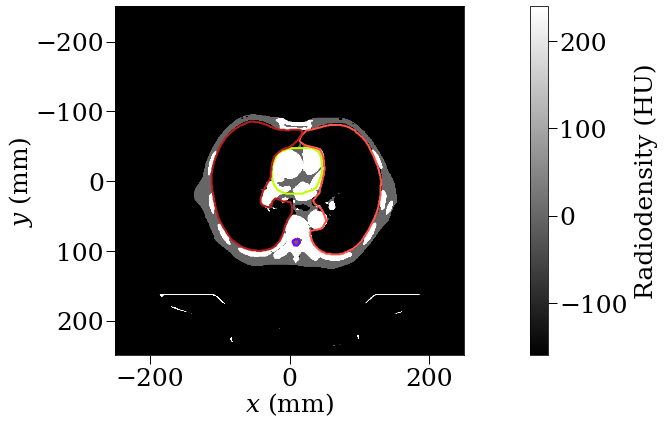

In [13]:
# Define mapping between intensity ranges in the original image
# and intensity value by which to represent them.
# None as first element in a range corresponds to
# the image's minimum intensity, and as second element
# corresponds to the image's maximum intensity.
bands = {-1024:(None, -100), 0:(-100, 100), 1024:(100, None)}

# Clone image, and apply banding.
im10 = images[0].clone(); im10.apply_selective_banding(bands=bands)

# View image.
im10.view(rois=structure_sets[0], colorbar=True);